# WAMR vs Wasmtime vs Native I2C Benchmark Analysis

This notebook analyzes the performance of different WebAssembly runtime implementations for I2C operations.

## Setup
Make sure you've run `cargo bench --benches` first and copied the `criterion/` directory to this location.

In [1]:
# Import required libraries
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from typing import Dict, List, Tuple
import warnings
import os
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
class CriterionAnalyzer:
    def __init__(self, criterion_dir: str = "criterion"):
        self.criterion_dir = Path(criterion_dir)
        self.results = {}
        self.df = None
        self.load_all_results()
    
    def load_all_results(self):
        """Load all Criterion benchmark results from JSON files"""
        if not self.criterion_dir.exists():
            raise FileNotFoundError(f"Criterion directory not found: {self.criterion_dir}")
        
        print(f"📂 Loading results from: {self.criterion_dir}")
        
        for group_dir in self.criterion_dir.iterdir():
            if group_dir.is_dir() and group_dir.name != "report":
                group_name = group_dir.name
                self.results[group_name] = {}
                
                # Look for subdirectories (benchmark functions within groups)
                for bench_dir in group_dir.iterdir():
                    if bench_dir.is_dir() and bench_dir.name != "report":
                        # Try to load sample data first (contains raw timing data)
                        sample_file = bench_dir / "base" / "sample.json"
                        estimates_file = bench_dir / "base" / "estimates.json"
                        
                        if sample_file.exists() and estimates_file.exists():
                            try:
                                # Load raw sample data
                                with open(sample_file, 'r') as f:
                                    sample_data = json.load(f)
                                
                                # Load statistical estimates  
                                with open(estimates_file, 'r') as f:
                                    estimates_data = json.load(f)
                                
                                # Combine the data
                                combined_data = {
                                    'samples': sample_data,
                                    'estimates': estimates_data
                                }
                                
                                self.results[group_name][bench_dir.name] = self._process_criterion_data(combined_data)
                                print(f"  ✓ Loaded {group_name}/{bench_dir.name}")
                            except Exception as e:
                                print(f"  ❌ Failed to load {group_name}/{bench_dir.name}: {e}")
        
        # Create DataFrame for easy analysis
        self.df = self.get_summary_dataframe()
        print(f"\n📊 Loaded {len(self.df)} benchmark results")
    
    def _process_criterion_data(self, data: dict) -> dict:
        """Process Criterion sample and estimates data into usable statistics"""
        try:
            # Extract raw timing data from samples
            samples = data.get('samples', {})
            estimates = data.get('estimates', {})
            
            # Get the sampling times (in nanoseconds)
            times_ns = []
            
            # Try different possible keys for timing data
            if 'sampling_times' in samples:
                times_ns = samples['sampling_times']
            elif 'times' in samples:
                times_ns = samples['times']
            elif 'iters' in samples and 'times' in samples:
                # Sometimes it's structured as iters and times arrays
                times = samples.get('times', [])
                iters = samples.get('iters', [])
                if len(times) == len(iters) and len(iters) > 0:
                    # Calculate time per iteration
                    times_ns = [t/i if i > 0 else 0 for t, i in zip(times, iters)]
            
            # If we still have no timing data, try to get it from estimates
            if not times_ns and 'mean' in estimates:
                # Use estimates mean as a single data point
                mean_estimate = estimates['mean']
                if 'point_estimate' in mean_estimate:
                    times_ns = [mean_estimate['point_estimate']]
                elif isinstance(mean_estimate, (int, float)):
                    times_ns = [mean_estimate]
            
            if not times_ns:
                print(f"    ⚠️  No timing data found in sample structure: {list(samples.keys())}")
                return {}
                
            # Keep in nanoseconds - ensure no negative values
            times_ns = [max(0, t) for t in times_ns]
            
            if not times_ns or all(t == 0 for t in times_ns):
                print(f"    ⚠️  All timing values are zero or negative")
                return {}
            
            # Calculate statistics (all in nanoseconds)
            stats = {
                'times_ns': times_ns,
                'mean_ns': np.mean(times_ns),
                'median_ns': np.median(times_ns),
                'std_ns': np.std(times_ns),
                'min_ns': np.min(times_ns),
                'max_ns': np.max(times_ns),
                'q25_ns': np.percentile(times_ns, 25),
                'q75_ns': np.percentile(times_ns, 75),
                'sample_count': len(times_ns),
                'cv': np.std(times_ns) / np.mean(times_ns) * 100 if np.mean(times_ns) > 0 else 0
            }
            
            return stats
            
        except Exception as e:
            print(f"    ❌ Error processing data: {e}")
            return {}
    
    def get_summary_dataframe(self) -> pd.DataFrame:
        """Create a pandas DataFrame with all results for easy analysis"""
        rows = []
        for group_name, group_data in self.results.items():
            for bench_name, stats in group_data.items():
                if stats:  # Skip empty results
                    rows.append({
                        'Group': group_name,
                        'Implementation': bench_name,
                        'Mean (ns)': stats['mean_ns'],
                        'Median (ns)': stats['median_ns'],
                        'Std Dev (ns)': stats['std_ns'],
                        'Min (ns)': stats['min_ns'],
                        'Max (ns)': stats['max_ns'],
                        'CV (%)': stats['cv'],
                        'Samples': stats['sample_count']
                    })
        return pd.DataFrame(rows)
    
    def get_raw_data(self) -> Dict:
        """Get raw timing data for detailed analysis"""
        raw_data = {}
        for group_name, group_data in self.results.items():
            raw_data[group_name] = {}
            for impl_name, stats in group_data.items():
                if stats and 'times_ns' in stats:
                    raw_data[group_name][impl_name] = stats['times_ns']
        return raw_data

print("✅ CriterionAnalyzer class defined!")

✅ CriterionAnalyzer class defined!


In [21]:
# Debug: Let's examine the structure of one sample file to understand the format
def debug_criterion_structure():
    criterion_path = Path("criterion")
    
    if not criterion_path.exists():
        print(f"❌ Directory 'criterion' not found in current directory")
        print(f"Current directory: {os.getcwd()}")
        print("Available directories:")
        for item in Path(".").iterdir():
            if item.is_dir():
                print(f"  📁 {item.name}")
        return
    
    # Find the first sample.json file to examine
    for group_dir in criterion_path.iterdir():
        if group_dir.is_dir() and group_dir.name != "report":
            for impl_dir in group_dir.iterdir():
                if impl_dir.is_dir() and impl_dir.name != "report":
                    print(impl_dir)
            #         sample_file = impl_dir / "base" / "sample.json"
                    
            #         if sample_file.exists():
            #             print(f"📋 Examining: {sample_file}")
            #             with open(sample_file, 'r') as f:
            #                 sample_data = json.load(f)
            #             print(f"Sample data keys: {list(sample_data.keys())}")
                        
            #             # Show a bit of the structure
            #             for key, value in sample_data.items():
            #                 if isinstance(value, list):
            #                     print(f"  {key}: list with {len(value)} items")
            #                     if len(value) > 0:
            #                         print(f"    First few items: {value[:3]}")
            #                 else:
            #                     print(f"  {key}: {type(value)} = {value}")
            #             return  # Only examine the first one

debug_criterion_structure()

criterion/Cold Ping Pong Execution/Wasmtime
criterion/Cold Ping Pong Execution/Native
criterion/Cold Ping Pong Execution/WAMR
criterion/Runtime Setup/Wasmtime
criterion/Runtime Setup/Native
criterion/Runtime Setup/WAMR
criterion/Hot Ping Pong Execution/Wasmtime
criterion/Hot Ping Pong Execution/Native
criterion/Hot Ping Pong Execution/WAMR


In [4]:
# Initialize the analyzer
analyzer = CriterionAnalyzer(criterion_dir="criterion")

# Display basic info
print(f"Found {len(analyzer.results)} benchmark groups:")
for group_name, group_data in analyzer.results.items():
    implementations = list(group_data.keys())
    print(f"  📋 {group_name}: {', '.join(implementations)}")
    
# If no data was loaded, show error
if not analyzer.results or all(not group_data for group_data in analyzer.results.values()):
    print("\n❌ No data loaded! Check the debug output above and ensure:")
    print("1. The 'criterion' directory exists in this directory")
    print("2. It contains the benchmark results from 'cargo bench'")
    print("3. The sample.json and estimates.json files are present")

📂 Loading results from: criterion
  ✓ Loaded Cold Ping Pong Execution/Wasmtime
  ✓ Loaded Cold Ping Pong Execution/Native
  ✓ Loaded Cold Ping Pong Execution/WAMR
  ✓ Loaded Runtime Setup/Wasmtime
  ✓ Loaded Runtime Setup/Native
  ✓ Loaded Runtime Setup/WAMR
  ✓ Loaded Hot Ping Pong Execution/Wasmtime
  ✓ Loaded Hot Ping Pong Execution/Native
  ✓ Loaded Hot Ping Pong Execution/WAMR

📊 Loaded 9 benchmark results
Found 3 benchmark groups:
  📋 Cold Ping Pong Execution: Wasmtime, Native, WAMR
  📋 Runtime Setup: Wasmtime, Native, WAMR
  📋 Hot Ping Pong Execution: Wasmtime, Native, WAMR


## Summary Statistics

In [5]:
# Display summary table
df = analyzer.df
if not df.empty:
    print("📊 BENCHMARK RESULTS SUMMARY")
    print("=" * 50)
    display(df.round(2))
else:
    print("❌ No benchmark data found. Make sure to run 'cargo bench --benches' first!")

📊 BENCHMARK RESULTS SUMMARY


,Group,Implementation,Mean (ns),Median (ns),Std Dev (ns),Min (ns),Max (ns),CV (%),Samples
0,Cold Ping Pong Execution,Wasmtime,6.524358e+07,65187318.5,3.728382e+07,1307459.0,1.291303e+08,57.15,100
1,Cold Ping Pong Execution,Native,2.996589e+08,299886172.0,1.710867e+08,5945720.0,5.941880e+08,57.09,100
2,Cold Ping Pong Execution,WAMR,3.054359e+08,305443713.5,1.748448e+08,6047923.0,6.057906e+08,57.24,100
3,Runtime Setup,Wasmtime,9.905308e+08,990465591.0,5.663378e+08,19639849.0,1.960633e+09,57.18,100
4,Runtime Setup,Native,2.965958e+08,297628888.0,1.692629e+08,5890106.0,5.857182e+08,57.07,100
5,Runtime Setup,WAMR,3.055704e+08,305331516.0,1.747717e+08,6044161.0,6.049562e+08,57.20,100
6,Hot Ping Pong Execution,Wasmtime,3.590322e+08,358975955.5,2.051791e+08,7145290.0,7.109653e+08,57.15,100
7,Hot Ping Pong Execution,Native,3.271901e+08,327278229.5,1.869702e+08,6483606.0,6.477865e+08,57.14,100
8,Hot Ping Pong Execution,WAMR,3.587382e+08,358743991.5,2.050512e+08,7108752.0,7.103339e+08,57.16,100


In [6]:
# Performance analysis per group
if not df.empty:
    print("🏆 PERFORMANCE WINNERS BY CATEGORY")
    print("=" * 40)
    
    for group_name in df['Group'].unique():
        group_df = df[df['Group'] == group_name].copy()
        group_df = group_df.sort_values('Mean (ns)')
        
        fastest = group_df.iloc[0]
        print(f"\n{group_name}:")
        print(f"  🥇 Winner: {fastest['Implementation']} ({fastest['Mean (ns)']:.0f}ns)")
        
        # Show relative performance
        for _, row in group_df.iterrows():
            relative_perf = row['Mean (ns)'] / fastest['Mean (ns)']
            emoji = "🥇" if relative_perf == 1.0 else "🥈" if relative_perf < 2.0 else "🥉" if relative_perf < 5.0 else "📊"
            print(f"    {emoji} {row['Implementation']}: {row['Mean (ns)']:.0f}ns [{relative_perf:.2f}x]")
        
        # Performance gap
        if len(group_df) > 1:
            slowest = group_df.iloc[-1]
            speedup = slowest['Mean (ns)'] / fastest['Mean (ns)']
            print(f"    📈 Performance gap: {speedup:.2f}x ({slowest['Mean (ns)'] - fastest['Mean (ns)']:.0f}ns)")

🏆 PERFORMANCE WINNERS BY CATEGORY

Cold Ping Pong Execution:
  🥇 Winner: Wasmtime (65243576ns)
    🥇 Wasmtime: 65243576ns [1.00x]
    🥉 Native: 299658902ns [4.59x]
    🥉 WAMR: 305435859ns [4.68x]
    📈 Performance gap: 4.68x (240192283ns)

Runtime Setup:
  🥇 Winner: Native (296595835ns)
    🥇 Native: 296595835ns [1.00x]
    🥈 WAMR: 305570405ns [1.03x]
    🥉 Wasmtime: 990530805ns [3.34x]
    📈 Performance gap: 3.34x (693934969ns)

Hot Ping Pong Execution:
  🥇 Winner: Native (327190101ns)
    🥇 Native: 327190101ns [1.00x]
    🥈 WAMR: 358738152ns [1.10x]
    🥈 Wasmtime: 359032207ns [1.10x]
    📈 Performance gap: 1.10x (31842106ns)


# 📊 Plot Interpretation Guide

This section explains how to interpret each type of plot and what to look for in your performance analysis.

## 🎯 General Principle: **LOWER IS BETTER**
For all timing measurements, **lower values = better performance** (faster execution).

---

## 📈 Bar Charts (Mean Performance)

**What it shows:** Average execution time with error bars (standard deviation)

**How to interpret:**
- **📏 Bar Height:** Lower bars = faster performance ✅
- **📐 Error Bars:** Shorter error bars = more consistent performance ✅
- **📊 Comparison:** Easy to compare average performance between implementations

**Look for:**
- Which implementation has the **shortest bars** (fastest average)
- Which has the **smallest error bars** (most consistent)
- Large differences between implementations (performance gaps)

---

## 📦 Box Plots (Distribution Analysis)

**What it shows:** Full distribution of all timing measurements

**Box plot anatomy:**
```
     ┬ ← Max (excluding outliers)
     │
   ┌─┴─┐ ← 75th percentile (Q3)
   │ ▬ │ ← Median (50th percentile)
   └─┬─┘ ← 25th percentile (Q1)
     │
     ┴ ← Min (excluding outliers)
     ● ← Outliers
```

**How to interpret:**
- **🎯 Median line (middle line):** Lower = better average performance
- **📦 Box height (Q3-Q1):** Shorter box = more consistent performance ✅
- **📐 Whiskers (top/bottom lines):** Shorter whiskers = less variability ✅
- **⚫ Outliers (dots):** Fewer outliers = more predictable performance ✅

**Look for:**
- **Lower median** (middle line in box)
- **Shorter, tighter boxes** (consistent performance)
- **Fewer outliers** (predictable behavior)

---

## 🌡️ Heatmap (Relative Performance)

**What it shows:** Relative performance comparison normalized within each benchmark group

**Color interpretation:**
- 🟢 **Green values (closer to 1.0):** Better relative performance ✅
- 🟡 **Yellow values (1.5-3.0):** Moderate performance
- 🔴 **Red values (>3.0):** Worse relative performance ❌

**How to read the numbers:**
- **1.00:** Best performer in that category (baseline)
- **2.50:** 2.5× slower than the best performer
- **5.00:** 5× slower than the best performer

**Look for:**
- **Green cells** (values close to 1.0) across multiple benchmark categories
- **Consistent patterns** - does one implementation always perform well?
- **Trade-offs** - good at setup but slow at execution, or vice versa

---

## 📋 Statistical Table

**Key metrics to focus on:**

| Metric | Better Value | What It Means |
|--------|-------------|---------------|
| **Mean (ns)** | Lower ⬇️ | Average execution time |
| **Median (ns)** | Lower ⬇️ | Middle value (less affected by outliers) |
| **Std Dev (ns)** | Lower ⬇️ | How much times vary (consistency) |
| **CV (%)** | Lower ⬇️ | Coefficient of Variation (relative consistency) |
| **Min (ns)** | Lower ⬇️ | Best-case performance |
| **Max (ns)** | Lower ⬇️ | Worst-case performance |

---

## 🎖️ Coefficient of Variation (CV) Guide

**CV measures consistency relative to the mean:**

| CV Range | Interpretation | Quality |
|----------|----------------|---------|
| **< 5%** | Very consistent ✅ | Excellent |
| **5-10%** | Moderately consistent ✅ | Good |
| **10-20%** | Somewhat variable ⚠️ | Fair |
| **> 20%** | Highly variable ❌ | Poor |

**Lower CV% = More predictable performance** ✅

---

## 🔍 What to Look For in Your Analysis

### For **Runtime Setup**:
- Which runtime initializes fastest?
- Is the overhead consistent or variable?

### For **Cold Execution** (first run):
- Which handles cold starts best?
- How much does compilation/initialization impact performance?

### For **Hot Execution** (repeated runs):
- Which runtime is fastest once warmed up?
- How consistent is the hot performance?

### Overall Questions:
1. **Speed:** Which implementation is fastest overall?
2. **Consistency:** Which implementation is most predictable?
3. **Trade-offs:** Are there setup vs. execution trade-offs?
4. **Use case fit:** Which runtime fits your specific use case best?

**Remember: The "best" choice depends on your specific requirements!** 🎯

## Interactive Visualizations

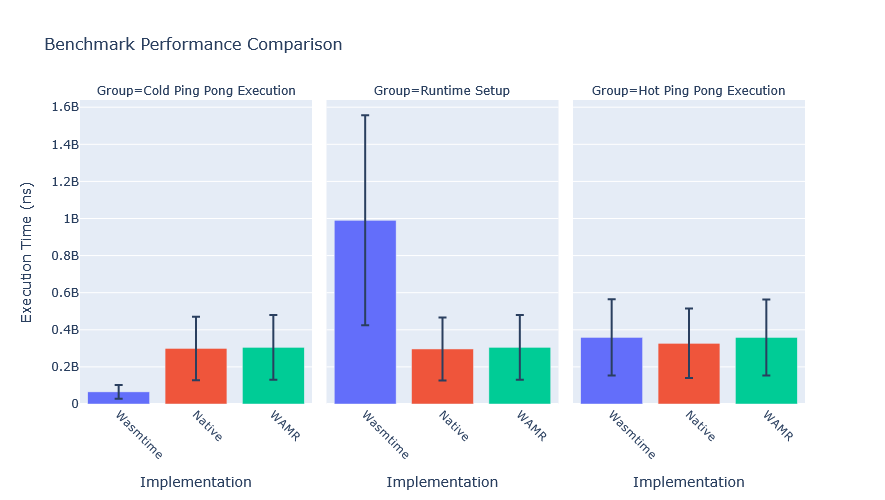

In [14]:
# Interactive bar chart with Plotly
if not df.empty:
    fig = px.bar(
        df, 
        x='Implementation', 
        y='Mean (ns)', 
        color='Implementation',
        facet_col='Group',
        error_y='Std Dev (ns)',
        title='Benchmark Performance Comparison',
        labels={'Mean (ns)': 'Execution Time (ns)'},
        height=500
    )
    
    fig.update_layout(
        showlegend=False,
        font=dict(size=12),
        title_font_size=16
    )
    
    # Rotate x-axis labels for better readability
    fig.update_xaxes(tickangle=45)
    
    fig.show()
else:
    print("❌ No data available for plotting.")

In [8]:
# Box plots showing distribution
if not df.empty:
    raw_data = analyzer.get_raw_data()
    
    # Prepare data for box plots
    plot_data = []
    for group_name, group_data in raw_data.items():
        for impl_name, times in group_data.items():
            for time in times:
                plot_data.append({
                    'Group': group_name,
                    'Implementation': impl_name,
                    'Time (ns)': time
                })
    
    if plot_data:
        plot_df = pd.DataFrame(plot_data)
        
        fig = px.box(
            plot_df,
            x='Implementation',
            y='Time (ns)',
            color='Implementation',
            facet_col='Group',
            title='Execution Time Distribution (Box Plots)',
            height=500
        )
        
        fig.update_layout(
            showlegend=False,
            font=dict(size=12),
            title_font_size=16
        )
        
        fig.update_xaxes(tickangle=45)
        fig.show()
else:
    print("❌ No raw data available for distribution plots.")

In [9]:
# Performance heatmap
if not df.empty and len(df['Group'].unique()) > 1:
    # Create pivot table for heatmap
    pivot_df = df.pivot(index='Implementation', columns='Group', values='Mean (ns)')
    
    # Calculate relative performance (normalize by minimum in each column)
    normalized_df = pivot_df.div(pivot_df.min(), axis=1)
    
    fig = px.imshow(
        normalized_df.values,
        x=normalized_df.columns,
        y=normalized_df.index,
        color_continuous_scale='RdYlGn_r',
        title='Relative Performance Heatmap<br><sub>Lower values (green) are better</sub>',
        labels=dict(color="Relative Performance"),
        text_auto='.2f'
    )
    
    fig.update_layout(
        width=800,
        height=400,
        font=dict(size=12),
        title_font_size=16
    )
    
    fig.show()
else:
    print("❌ Not enough data for heatmap (need multiple benchmark groups).")

## Static Matplotlib Plots

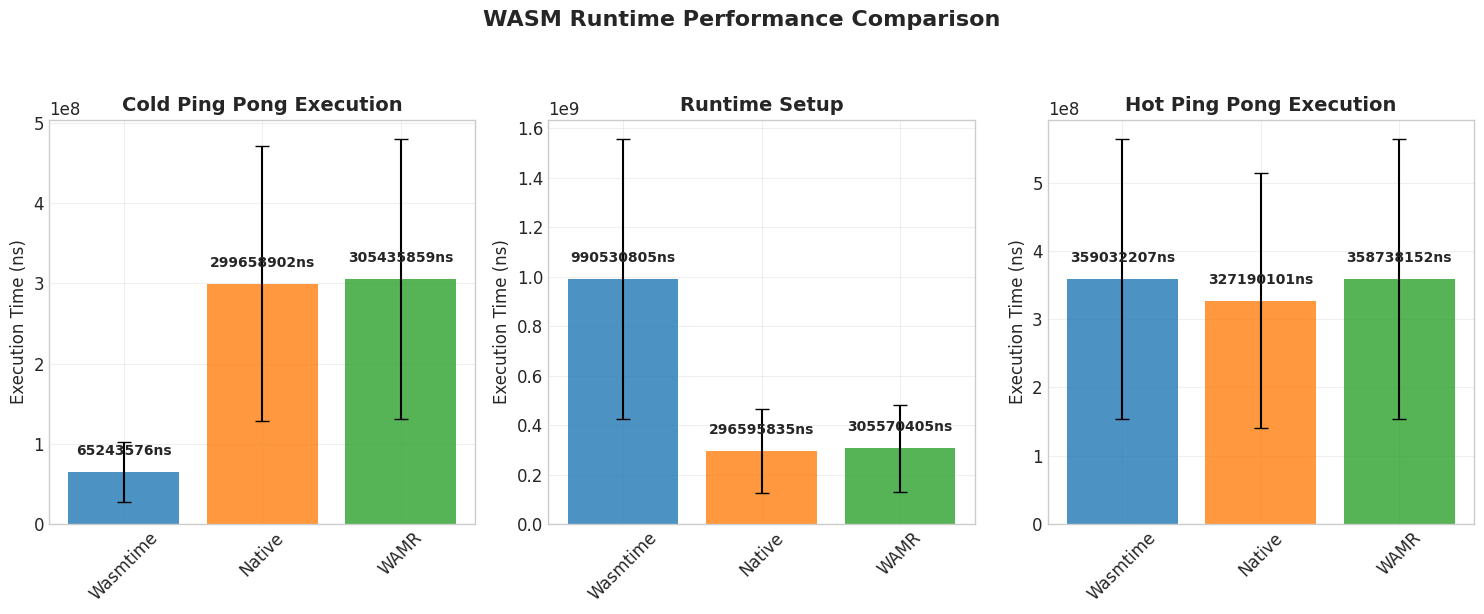

💾 Plot saved as 'benchmark_comparison.png'


In [10]:
# Traditional matplotlib plots for publication
if not df.empty:
    groups = df['Group'].unique()
    n_groups = len(groups)
    
    fig, axes = plt.subplots(1, n_groups, figsize=(5*n_groups, 6))
    if n_groups == 1:
        axes = [axes]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for idx, group_name in enumerate(groups):
        group_data = df[df['Group'] == group_name]
        
        bars = axes[idx].bar(
            group_data['Implementation'],
            group_data['Mean (ns)'],
            yerr=group_data['Std Dev (ns)'],
            capsize=5,
            alpha=0.8,
            color=colors[:len(group_data)]
        )
        
        axes[idx].set_title(f'{group_name}', fontweight='bold', fontsize=14)
        axes[idx].set_ylabel('Execution Time (ns)', fontsize=12)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, mean_val in zip(bars, group_data['Mean (ns)']):
            height = bar.get_height()
            axes[idx].text(
                bar.get_x() + bar.get_width()/2.,
                height + max(group_data['Std Dev (ns)'])/10,
                f'{mean_val:.0f}ns',
                ha='center', va='bottom', fontsize=10, fontweight='bold'
            )
    
    plt.suptitle('WASM Runtime Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    fig.savefig('benchmark_comparison.png', dpi=300, bbox_inches='tight')
    print("💾 Plot saved as 'benchmark_comparison.png'")
else:
    print("❌ No data available for matplotlib plots.")

## Detailed Statistical Analysis

In [11]:
# Statistical significance testing (if you want to add this later)
if not df.empty:
    print("📈 COEFFICIENT OF VARIATION (Consistency Measure)")
    print("Lower CV% = more consistent performance")
    print("=" * 50)
    
    cv_df = df[['Group', 'Implementation', 'CV (%)']].sort_values(['Group', 'CV (%)'])
    display(cv_df.round(2))
    
    print("\n💡 Interpretation:")
    print("   • CV < 5%: Very consistent")
    print("   • CV 5-10%: Moderately consistent")
    print("   • CV > 10%: High variability")

📈 COEFFICIENT OF VARIATION (Consistency Measure)
Lower CV% = more consistent performance


,Group,Implementation,CV (%)
1,Cold Ping Pong Execution,Native,57.09
0,Cold Ping Pong Execution,Wasmtime,57.15
2,Cold Ping Pong Execution,WAMR,57.24
7,Hot Ping Pong Execution,Native,57.14
6,Hot Ping Pong Execution,Wasmtime,57.15
8,Hot Ping Pong Execution,WAMR,57.16
4,Runtime Setup,Native,57.07
3,Runtime Setup,Wasmtime,57.18
5,Runtime Setup,WAMR,57.20



💡 Interpretation:
   • CV < 5%: Very consistent
   • CV 5-10%: Moderately consistent
   • CV > 10%: High variability


In [12]:
# Export results for further analysis
if not df.empty:
    # Save to CSV
    df.to_csv('benchmark_results.csv', index=False)
    print("💾 Results exported to 'benchmark_results.csv'")
    
    # Export raw data as JSON for other tools
    raw_data = analyzer.get_raw_data()
    with open('raw_benchmark_data.json', 'w') as f:
        json.dump(raw_data, f, indent=2)
    print("💾 Raw data exported to 'raw_benchmark_data.json'")
else:
    print("❌ No data to export.")

💾 Results exported to 'benchmark_results.csv'
💾 Raw data exported to 'raw_benchmark_data.json'


## Notes for Master's Thesis

### 🎯 Key Performance Insights for Your Analysis

**1. Setup Overhead Analysis:**
- Compare initialization costs between Native, WAMR, and Wasmtime
- WASM runtimes will typically have higher setup overhead due to module loading/compilation
- Look for: Which runtime has the fastest "time to first execution"?

**2. Cold vs Hot Performance:**
- **Cold:** Includes compilation, optimization, and first-run overhead
- **Hot:** Steady-state performance after warmup
- Expected pattern: Cold > Hot (first run is usually slower)
- Look for: How much does each runtime improve from cold to hot?

**3. Consistency Analysis (CV%):**
- Lower CV% = more predictable performance
- Important for real-time or embedded systems
- Look for: Which runtime has the most consistent performance?

**4. Performance Trade-offs:**
- **Native:** Fastest execution, but no sandboxing/portability
- **WAMR:** Optimized for embedded, smaller footprint
- **Wasmtime:** Full-featured, more optimizations, larger footprint

### 📊 Expected Results Patterns

Based on typical WASM runtime characteristics:

| Metric | Expected Ranking (Best to Worst) |
|--------|-----------------------------------|
| **Setup Speed** | Native > WAMR > Wasmtime |
| **Hot Execution** | Native > Wasmtime ≈ WAMR |
| **Consistency** | Native > WAMR > Wasmtime |
| **Memory Usage** | Native < WAMR < Wasmtime |

### 🔬 Statistical Significance

For rigorous analysis:
- Run benchmarks multiple times (different sessions)
- Check if performance differences are statistically significant
- Consider: Are the differences large enough to matter in practice?

### 📝 Thesis Writing Tips

**For your results section:**
1. Start with the summary table (quantitative overview)
2. Use bar charts to show main performance differences
3. Use box plots to discuss consistency/variability
4. Use heatmap to show relative performance patterns
5. Discuss practical implications of the differences

**Key questions to answer:**
- Is the performance overhead of WASM acceptable for I2C operations?
- Which runtime offers the best balance of performance vs. features?
- How do the results align with your expectations?
- What are the practical implications for embedded systems?

**Remember:** Context matters! A 10× overhead might be acceptable if absolute times are still microseconds, but problematic if they're milliseconds.